<a href="https://colab.research.google.com/github/RonakRaj-dev/Sign-Bridge-ML-model/blob/main/Sign_Bridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python mediapipe matplotlib tensorflow[and-cuda]

  Using cached nvidia_cublas_cu12-12.3.4.1-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.3.101-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvcc_cu12-12.3.107-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.3.107-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.3.101-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cudnn_cu12-8.9.7.29-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.0.12.1-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.4.107-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.5.4.101-py3-none-win_amd64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.2.0.103-py3-none-win_amd64.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. Th

ERROR: Cannot install tensorflow, tensorflow[and-cuda]==2.16.1, tensorflow[and-cuda]==2.16.2, tensorflow[and-cuda]==2.17.0, tensorflow[and-cuda]==2.17.1 and tensorflow[and-cuda]==2.18.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import mediapipe as mp

In [ ]:
mp_holistic = mp.solutions.holistic # this is a holistic model - use to make a detection
mp_drawing = mp.solutions.drawing_utils # these are drawing utilities - use to draw them

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
def draw_landmark(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
        )

    # Draw specific pose connections (shoulders, elbows, hands, and neck)
    if results.pose_landmarks:
        # Define the pose connections to retain
        custom_pose_connections = [
            (11, 12),  # Left shoulder to right shoulder (neck area)
            (11, 13),  # Left shoulder to left elbow
            (13, 15),  # Left elbow to left hand
            (12, 14),  # Right shoulder to right elbow
            (14, 16),  # Right elbow to right hand
        ]

        for connection in custom_pose_connections:
            start_idx, end_idx = connection
            start = results.pose_landmarks.landmark[start_idx]
            end = results.pose_landmarks.landmark[end_idx]

            # Get coordinates
            start_x, start_y = int(start.x * image.shape[1]), int(start.y * image.shape[0])
            end_x, end_y = int(end.x * image.shape[1]), int(end.y * image.shape[0])

            # Draw the connection
            cv2.line(image, (start_x, start_y), (end_x, end_y), (80, 22, 10), 2)  # Line between joints

            # Draw the joints
            cv2.circle(image, (start_x, start_y), 5, (80, 22, 10), -1)
            cv2.circle(image, (end_x, end_y), 5, (80, 22, 10), -1)

    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
        )

    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [ ]:
# video_path = '/content/drive/MyDrive/FIXXLINK/DataSets/Actor/Actor (1).MOV'
video_path = os.path.abspath("MVI_9370.MOV")
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Cannot open video file at {video_path}")

In [ ]:
# from google.colab.patches import cv2_imshow

# Initialize the holistic model
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()  # Read a frame from the video
        if not ret:  # If no frame is returned, the video has ended
            break

        # Perform detection using MediaPipe
        image, results = mediapipe_detection(frame, holistic)

        # Draw the landmarks on the frame
        draw_landmark(image, results)

        # # Display the frame with the markings
        # cv2_imshow(image)

        # Break the loop if 'x' is pressed
        if cv2.waitKey(10) & 0xFF == ord('x'):
            break

# Release video capture and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

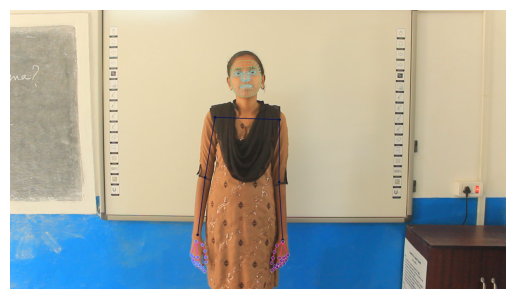

In [ ]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image for matplotlib
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
len(results.pose_landmarks.landmark)

33

In [ ]:
pose_indices = [11, 12, 13, 14, 15, 16]  # Indices for shoulders, elbows, and hands
pose = []

for idx in pose_indices:
    res = results.pose_landmarks.landmark[idx]
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

print(len(pose))


6


In [ ]:
# Extract only specific pose landmarks: shoulders, elbows, and wrists
pose_indices = [11, 12, 13, 14, 15, 16]  # Indices for shoulders, elbows, and wrists
pose = np.array([[res.x, res.y, res.z, res.visibility] for idx, res in enumerate(results.pose_landmarks.landmark) if idx in pose_indices]).flatten() if results.pose_landmarks else np.zeros(len(pose_indices) * 4)

# Extract face landmarks
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

# Extract left hand landmarks
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)

# Extract right hand landmarks
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21 * 3)

print(pose.shape, face.shape, lh.shape, rh.shape)


(24,) (1404,) (63,) (63,)


In [ ]:
def extract_keypoints(results):
    # Extract only specific pose landmarks: shoulders, elbows, and wrists
    pose_indices = [11, 12, 13, 14, 15, 16]  # Indices for shoulders, elbows, and wrists
    pose = (
        np.array(
            [[res.x, res.y, res.z, res.visibility] for idx, res in enumerate(results.pose_landmarks.landmark) if idx in pose_indices]
        ).flatten() if results.pose_landmarks else np.zeros(len(pose_indices) * 4)
    )

    # Extract face landmarks
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468 * 3)

    # Extract left hand landmarks
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)

    # Extract right hand landmarks
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21 * 3)

    # Combine and return all keypoints
    return np.concatenate([pose, face, lh, rh])


In [ ]:
result_test = extract_keypoints(results)[:-10]

In [ ]:
result_test

array([ 0.54355711,  0.39319617, -0.31031278, ...,  0.00523263,
        0.36559701,  0.87675691])

In [ ]:
np.save('0', result_test)

In [ ]:
np.load('0.npy')

array([ 0.54355711,  0.39319617, -0.31031278, ...,  0.00523263,
        0.36559701,  0.87675691])

# ***Setup Folders for Collection***

In [ ]:
from pathlib import Path

# folder_path = Path("/content/drive/MyDrive")
folder_path = Path(r"C:\Users\gamer")

action_array = ["Doctor", "God", "Key", "Manager", "Morning", "Sunday"]
# video folder path
video_folder = Path(r"C:\Users\gamer\DataSets")
print(video_folder)

# Path for exported data, numpy arrays
DATA_PATH = os.path.join(folder_path, 'MP_Data')
print(DATA_PATH)

# Actions that we try to detect
actions = sorted([folder.name for folder in video_folder.iterdir() if folder.is_dir() and folder.name in action_array])
print(f"Actions detected: {actions}")

# Videos are going to be 30 frames in length
sequence_length = 15

C:\Users\gamer\DataSets
C:\Users\gamer\MP_Data
Actions detected: ['Doctor', 'God', 'Key', 'Manager', 'Morning', 'Sunday']


In [ ]:
# Ensure each action folder is created first, then create sequence folders within each
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    os.makedirs(action_path, exist_ok=True)  # Create main folder for each action if it doesn't exist

    # Path to the videos in the current action folder
    video_path = os.path.join(video_folder, action)

    # Count the number of video files in the folder
    num_videos = len([file for file in os.listdir(video_path) if file.endswith(('.MOV'))])
    print(f"Number of videos in {action}: {num_videos}")

    # Check for the maximum directory number in the action folder
    dirmax = np.max(np.array(os.listdir(action_path)).astype(int)) if os.listdir(action_path) else 0

    # Create sequence folders inside the action folder
    for sequence in range(1, num_videos + 1):  # Create folders equal to the number of videos
        try:
            os.makedirs(os.path.join(action_path, str(dirmax + sequence)))
        except Exception as e:
            print(f"Error creating folder for {action} sequence {sequence}: {e}")
    print(f"Created folders for action: {action} at {action_path}")
    num_videos = 0


Number of videos in Doctor: 11
Created folders for action: Doctor at C:\Users\gamer\MP_Data\Doctor
Number of videos in God: 7
Created folders for action: God at C:\Users\gamer\MP_Data\God
Number of videos in Key: 7
Created folders for action: Key at C:\Users\gamer\MP_Data\Key
Number of videos in Manager: 11
Created folders for action: Manager at C:\Users\gamer\MP_Data\Manager
Number of videos in Morning: 11
Created folders for action: Morning at C:\Users\gamer\MP_Data\Morning
Number of videos in Sunday: 11
Created folders for action: Sunday at C:\Users\gamer\MP_Data\Sunday


# *Colllecting the Keypoints for Training and Testing*

In [ ]:
# from google.colab.patches import cv2_imshow  # Ensure this is imported when using cv2_imshow

# Start processing videos
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        # Get subfolders for the current action
        video_action_path = os.path.join(video_folder, action)
        action_folder_path = os.path.join(DATA_PATH, action)
        video_num = len([file for file in os.listdir(video_action_path) if file.endswith(('.MOV'))])
        if not os.path.exists(video_action_path):
            print(f"Video folder for action '{action}' not found. Skipping...")
            continue

        for sequence_num in range(1, video_num + 1):  # Loop through all video files
            video_path = os.path.join(video_action_path, f"{action} ({sequence_num}).MOV")  # Replace with video file pattern if needed
            output_sequence_path = os.path.join(action_folder_path, str(sequence_num))

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Cannot open video file: {video_path}")
                continue

            # Start video after 200 milliseconds
            cap.set(cv2.CAP_PROP_POS_MSEC, 200)

            frame_count = 0
            print(f"Processing video {sequence_num} for action '{action}'...")
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Get the current timestamp in milliseconds
                current_time_ms = cap.get(cv2.CAP_PROP_POS_MSEC)

                # Stop processing if the elapsed time exceeds 3000 ms
                if current_time_ms > 3000:
                    break

                # Perform detection and draw landmarks
                try:
                    image, results = mediapipe_detection(frame, holistic)
                    draw_landmark(image, results)

                    # Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(output_sequence_path, f"{frame_count}.npy")
                    np.save(npy_path, keypoints)
                    frame_count += 1

                    # Stop after 32 frames
                    if frame_count == sequence_length:
                        break
                except Exception as e:
                    print(f"Error processing frame in video {video_path}: {e}")
                    break

            cap.release()
            print(f"Processed video {video_path} and saved keypoints to {output_sequence_path}")
            cv2.destroyAllWindows()

print("All videos processed!")


Processing video 1 for action 'Doctor'...
Processed video C:\Users\gamer\DataSets\Doctor\Doctor (1).MOV and saved keypoints to C:\Users\gamer\MP_Data\Doctor\1
Processing video 2 for action 'Doctor'...
Processed video C:\Users\gamer\DataSets\Doctor\Doctor (2).MOV and saved keypoints to C:\Users\gamer\MP_Data\Doctor\2
Processing video 3 for action 'Doctor'...
Processed video C:\Users\gamer\DataSets\Doctor\Doctor (3).MOV and saved keypoints to C:\Users\gamer\MP_Data\Doctor\3
Processing video 4 for action 'Doctor'...
Processed video C:\Users\gamer\DataSets\Doctor\Doctor (4).MOV and saved keypoints to C:\Users\gamer\MP_Data\Doctor\4
Processing video 5 for action 'Doctor'...
Processed video C:\Users\gamer\DataSets\Doctor\Doctor (5).MOV and saved keypoints to C:\Users\gamer\MP_Data\Doctor\5
Processing video 6 for action 'Doctor'...
Processed video C:\Users\gamer\DataSets\Doctor\Doctor (6).MOV and saved keypoints to C:\Users\gamer\MP_Data\Doctor\6
Processing video 7 for action 'Doctor'...
Proc

# *Preprocess Data and Create Labels and Features*

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_nap = {label : num for num, label in enumerate(actions)}

In [ ]:
label_nap

{'Doctor': 0, 'God': 1, 'Key': 2, 'Manager': 3, 'Morning': 4, 'Sunday': 5}

# **This code is to delete all duplicate videos Be Cautious !!!!!**

In [ ]:
import os
import shutil

# Paths
video_folder = Path("/content/drive/MyDrive/FIXXLINK/DataSets")  # Replace with the actual path to your video folder
DATA_PATH = os.path.join(folder_path, 'MP_Data')    # Replace with the actual path to your MP_DATA folder

# Actions list
actions = np.array([folder.name for folder in video_folder.iterdir() if folder.is_dir()])
actions.sort()

# Loop through each action
for action in actions:
    video_action_folder = os.path.join(video_folder, action)
    mp_data_folder = os.path.join(DATA_PATH, action)

    # Ensure paths exist
    if not os.path.exists(video_action_folder):
        print(f"Video folder for action '{action}' not found. Skipping...")
        continue
    if not os.path.exists(mp_data_folder):
        print(f"MP_DATA folder for action '{action}' not found. Skipping...")
        continue

    # Count videos and subfolders
    video_count = len([file for file in os.listdir(video_action_folder) if file.endswith(('.MOV'))])
    subfolder_count = len([folder for folder in os.listdir(mp_data_folder) if os.path.isdir(os.path.join(mp_data_folder, folder))])

    print(f"Action '{action}': {video_count} videos, {subfolder_count} subfolders")

    # Delete extra subfolders if they exist
    if subfolder_count > video_count:
        extra_subfolders = sorted(
            [folder for folder in os.listdir(mp_data_folder) if os.path.isdir(os.path.join(mp_data_folder, folder))],
            key=lambda x: int(x) if x.isdigit() else float('inf')  # Sort numerically
        )[video_count:]  # Get extra subfolders beyond the video count

        for folder in extra_subfolders:
            folder_path = os.path.join(mp_data_folder, folder)
            try:
                shutil.rmtree(folder_path)  # Remove the folder and its contents
                print(f"Deleted extra subfolder: {folder_path}")
            except Exception as e:
                print(f"Error deleting folder {folder_path}: {e}")

print("Subfolder cleanup completed!")


Action 'Actor': 11 videos, 11 subfolders
Action 'Adult': 19 videos, 19 subfolders
Action 'Afternoon': 11 videos, 11 subfolders
Action 'Alive': 8 videos, 8 subfolders
Action 'Alright': 21 videos, 21 subfolders
Action 'Animal': 18 videos, 18 subfolders
Action 'Artist': 11 videos, 11 subfolders
Action 'Attack': 8 videos, 8 subfolders
Action 'Author': 11 videos, 11 subfolders
Action 'Baby': 19 videos, 19 subfolders
Action 'Bad': 21 videos, 21 subfolders
Action 'Bag': 7 videos, 7 subfolders
Action 'Ball': 7 videos, 7 subfolders
Action 'Bank': 22 videos, 22 subfolders
Action 'Bathroom': 7 videos, 14 subfolders
Deleted extra subfolder: /content/drive/MyDrive/MP_Data/Bathroom/8
Deleted extra subfolder: /content/drive/MyDrive/MP_Data/Bathroom/9
Deleted extra subfolder: /content/drive/MyDrive/MP_Data/Bathroom/10
Deleted extra subfolder: /content/drive/MyDrive/MP_Data/Bathroom/11
Deleted extra subfolder: /content/drive/MyDrive/MP_Data/Bathroom/12
Deleted extra subfolder: /content/drive/MyDrive/MP

In [ ]:
# for action in actions:
#     action_path = os.path.join(DATA_PATH, action)
#     print(action_path)
#     print(sorted(np.array(os.listdir(action_path)).astype(int)))

/content/drive/MyDrive/MP_Data/Doctor
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
/content/drive/MyDrive/MP_Data/God
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
/content/drive/MyDrive/MP_Data/Key
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
/content/drive/MyDrive/MP_Data/Manager
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
/content/drive/MyDrive/MP_Data/Morning
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
/content/drive/MyDrive/MP_Data/Sunday
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
sequences, labels = [], []

# Define a label map for actions
label_map = {action: i for i, action in enumerate(actions)}
print(label_map)

def process_action(action):
    """Processes sequences for a single action."""
    action_path = os.path.join(DATA_PATH, action)
    action_sequences = []
    action_labels = []

    # Check if the action folder exists and is not empty
    if not os.path.exists(action_path) or len(os.listdir(action_path)) == 0:
        print(f"Warning: No sequences found for action '{action}' or directory does not exist.")
        return [], []

    try:
        # Get subdirectories sorted numerically
        sequence_folders = sorted(os.listdir(action_path), key=lambda x: int(x))
    except ValueError as e:
        print(f"Error: Non-numerical folder names found in {action_path}: {e}")
        return [], []
    print(sequence_folders)

    for sequence in sequence_folders:
        sequence_path = os.path.join(action_path, sequence)

        # Check if the sequence folder is valid
        if not os.path.isdir(sequence_path):
            print(f"Warning: '{sequence_path}' is not a valid directory. Skipping...")
            continue

        # # Check if the first frame exists in the folder
        # first_frame_path = os.path.join(sequence_path, "0.npy")
        # if not os.path.exists(first_frame_path):
        #     print(f"Warning: First frame not found in '{sequence_path}'. Deleting folder...")
        #     try:
        #         # Remove the folder and its contents
        #         for file in os.listdir(sequence_path):
        #             os.remove(os.path.join(sequence_path, file))
        #         os.rmdir(sequence_path)
        #         print(f"Deleted folder '{sequence_path}' as it contains no frames.")
        #     except Exception as e:
        #         print(f"Error deleting folder '{sequence_path}': {e}")
        #     continue

        window = []
        for frame_num in range(sequence_length):
            # Construct the file path
            file_path = os.path.join(sequence_path, f"{frame_num}.npy")

            # Check if the file exists before loading
            if os.path.exists(file_path):
                res = np.load(file_path)
                window.append(res)
            else:
                print(f"Warning: File {file_path} not found. Adding placeholder data.")
                window.append(np.zeros(1554))  # Placeholder data

        # Ensure the window has the correct length
        if len(window) == sequence_length:
            action_sequences.append(window)
            action_labels.append(label_map[action])
        else:
            print(f"Warning: Incomplete sequence for {action}, sequence {sequence}. Skipping...")

    return action_sequences, action_labels


# # Run in parallel for each action
# if __name__ == "__main__": # Changed _name_ to __name__
#     from multiprocessing import Pool
#     with Pool() as pool:
#         results = pool.map(process_action, actions)

#     # Combine results from all actions
#     for action_sequences, action_labels in results:
#         sequences.extend(action_sequences)
#         labels.extend(action_labels)

for action in actions:
    action_sequences, action_labels = process_action(action)
    sequences.extend(action_sequences)
    labels.extend(action_labels)

print(f"Processed {len(sequences)} sequences and {len(labels)} labels.")

{'Doctor': 0, 'God': 1, 'Key': 2, 'Manager': 3, 'Morning': 4, 'Sunday': 5}
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
['1', '2', '3', '4', '5', '6', '7']
['1', '2', '3', '4', '5', '6', '7']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
Processed 58 sequences and 58 labels.


In [ ]:
np.array(sequences).shape

(58, 15, 1554)

In [ ]:
np.array(labels).shape

(58,)

In [ ]:
X = np.array(sequences)

In [ ]:
X.shape

(58, 15, 1554)

In [ ]:
y = to_categorical(labels).astype(int)

In [ ]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [ ]:
y_test.shape

(3, 6)

# ***Build and Train LSTM Neural Network***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join(folder_path, 'Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
# In the cell where you create your model (ipython-input-69)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.3))
model.add(LSTM(128, return_sequences=True, activation='relu', dropout=0.3))
model.add(LSTM(64, return_sequences=False, activation='relu', dropout=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))  # Use softmax for classification

C:\Users\gamer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback], verbose=1)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9203 - loss: 0.1345
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9653 - loss: 0.0701
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9775 - loss: 0.0322
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9532 - loss: 0.0923
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9428 - loss: 0.1254
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9653 - loss: 0.1093
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9879 - loss: 0.0551
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0097
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9324 - loss: 0.1108
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9775 - loss: 0.0746
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9879 - loss: 0.0388
Epoch 12/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy:

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 15, 64)              │         414,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 15, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,701,716 (6.49 MB)

 Trainable params: 567,238 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,134,478 (4.33 MB)

# *Make Prediction*

In [ ]:
X_test

array([[[ 0.57104301,  0.37891296, -0.34499687, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.57098955,  0.37705532, -0.35445207, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.57098979,  0.37469545, -0.32362023, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.56694782,  0.36899883, -0.1025736 , ...,  0.51565248,
          0.45448917, -0.01823192],
        [ 0.5666526 ,  0.36795223, -0.10591313, ...,  0.51746076,
          0.45742014, -0.01846611],
        [ 0.56644386,  0.36747584, -0.11609768, ...,  0.51582021,
          0.4581199 , -0.01793768]],

       [[ 0.5648486 ,  0.31163612, -0.04889029, ...,  0.4039616 ,
          0.77544397,  0.00226886],
        [ 0.56816584,  0.31252199, -0.04832599, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.56936699,  0.31451756, -0.04762357, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.56727719,  0.30853784, -0.03100651, ...,  

In [ ]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


In [ ]:
res

array([[3.4366760e-03, 3.1700974e-06, 4.1498610e-05, 9.9596524e-01,
        3.0618623e-05, 5.2274321e-04],
       [1.8413959e-03, 2.4604009e-01, 6.3900810e-01, 1.1378977e-04,
        1.1167999e-01, 1.3166621e-03],
       [2.5588943e-04, 2.0315299e-02, 2.9290538e-06, 1.4968142e-03,
        1.2448023e-03, 9.7668433e-01]], dtype=float32)

In [ ]:
np.argmax(res)

3

In [ ]:
actions[np.argmax(res[0])]

'Manager'

In [ ]:
actions[np.argmax(y_test[0])]

'Doctor'

# *Save Weights*

In [ ]:
# model.save('/content/drive/MyDrive/action.keras')
model.save('action3.keras')

In [ ]:
# model.load_weights(Path('/content/drive/MyDrive/action.keras'))
model.load_weights(Path('action3.keras'))

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# loaded_model = load_model(Path('/content/drive/MyDrive/action.keras'))
loaded_model = load_model(Path('action3.keras'))

In [ ]:
loaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 15, 64)              │         414,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 15, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,701,716 (6.49 MB)

 Trainable params: 567,238 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,134,478 (4.33 MB)

# **Evaluation using Confusion Matrix and Accuracy**

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [ ]:
yhat

array([[3.4366760e-03, 3.1700974e-06, 4.1498610e-05, 9.9596524e-01,
        3.0618623e-05, 5.2274321e-04],
       [1.8413959e-03, 2.4604009e-01, 6.3900810e-01, 1.1378977e-04,
        1.1167999e-01, 1.3166621e-03],
       [2.5588943e-04, 2.0315299e-02, 2.9290538e-06, 1.4968142e-03,
        1.2448023e-03, 9.7668433e-01]], dtype=float32)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 0],
        [1, 0]],

       [[2, 1],
        [0, 0]],

       [[2, 1],
        [0, 0]],

       [[1, 0],
        [1, 1]]], dtype=int64)

In [ ]:
accuracy_score(ytrue, yhat)

0.3333333333333333

# **Test in Real Time**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()

    # Ensure `res` is a 1D array
    if len(res.shape) > 1:
        res = res.flatten()

    # Get the length of colors and res/actions (assuming they have the same length)
    num_colors = len(colors)
    num_actions = len(actions)

    for num, prob in enumerate(res):
        prob = float(prob)  # Convert prob to a scalar if it's not already

        # Use modulo operator to cycle through colors if num exceeds available colors
        color_index = num % num_colors

        # Check if num is within the bounds of actions before accessing it
        if num < num_actions:
            cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[color_index], -1)
            cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        else:
            # Handle the case where num is out of bounds for actions (optional)
            break  # Stop the loop or print a warning

    return output_frame

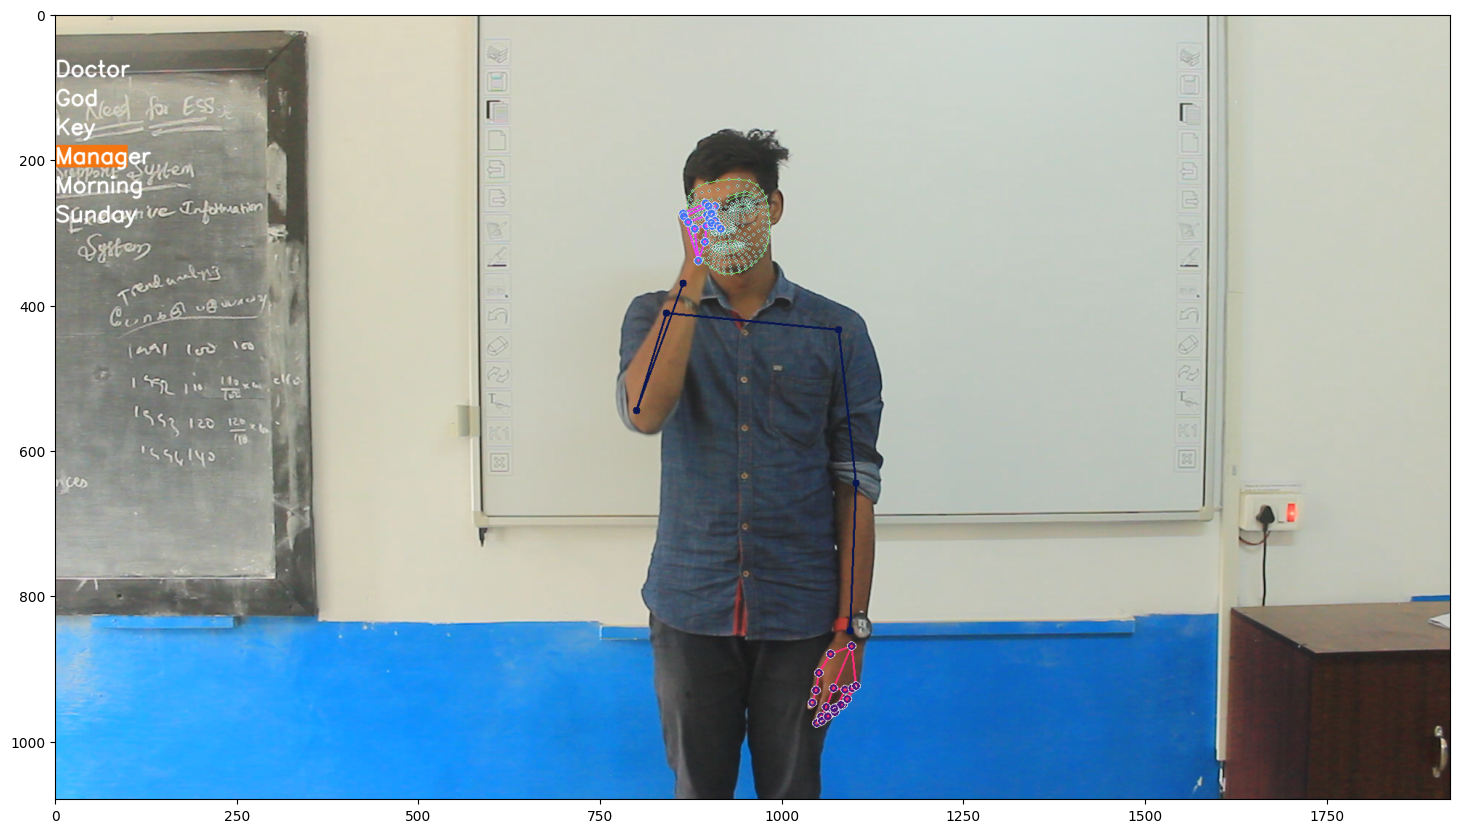

In [ ]:
plt.figure(figsize=(18, 18))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(prob_viz(res, actions, image_rgb, colors), cmap=None)
plt.show()

In [ ]:
import cv2
import numpy as np
import mediapipe as mp

# Initialize required variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

# Initialize MediaPipe Holistic model
mp_holistic = mp.solutions.holistic

# Set up video capture (using webcam)
# cap = cv2.VideoCapture('/content/drive/MyDrive/FIXXLINK/DataSets/Manager/Manager (2).MOV')  # Use '0' for webcam or provide a path to a video file
video_test_path = os.path.abspath(r"C:\Users\gamer\DataSets\Manager\Manager (2).MOV")
cap = cv2.VideoCapture(video_test_path)  # Use '0' for webcam or provide a path to a video file

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()  # Read frame from the camera
        if not ret:
            break

        # Perform detection
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks with lines on the image (optional for debugging)
        draw_landmark(image, results)

        # Prediction Logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-32:]  # Keep the last 32 frames

        # Only make predictions if we have 30 frames
        if len(sequence) == 32:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_action = actions[np.argmax(res)]  # Get the predicted action
            predictions.append(np.argmax(res))

            # Prediction filtering: Only show predictions when consistent for the last 10 frames
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) == 0 or predicted_action != sentence[-1]:
                        sentence.append(predicted_action)

            # Keep the sentence to a maximum of 5 words
            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Print the most accurate predicted action
            print(predicted_action)

        # Optionally, draw the sentence on the screen (if you want it)
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show the live video feed (optional)
        cv2.imshow("Final Image",frame)  # Show the current frame as the image for the action

        # Break gracefully if 'x' is pressed
        if cv2.waitKey(10) & 0xFF == ord('x'):
            break

    cap.release()  # Release the webcam
    cv2.destroyAllWindows()  # Close OpenCV windows


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sunday
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sunday
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sunday
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sunday
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Morning
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Morning
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Morning
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sunday
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Manager
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Doctor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Doctor
1/1 ━

In [ ]:
from collections import Counter

# New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5
window_size = 10  # Number of frames to track predictions

# Set up video capture
video_test_path = os.path.abspath(r"C:\Users\gamer\DataSets\Manager\Manager (3).MOV")
cap = cv2.VideoCapture(video_test_path)

# Load Mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform detection
        image, results = mediapipe_detection(frame, holistic)
        draw_landmark(image, results)

        # Extract keypoints
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-15:]

        # Make predictions if we have enough frames
        if len(sequence) == 15:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_action = actions[np.argmax(res)]  # Action with highest confidence

            predictions.append(predicted_action)  # Store prediction
            predictions = predictions[-window_size:]  # Keep only last N predictions

            # Find the most frequently predicted action in last N frames
            most_common_action = max(set(predictions), key=predictions.count)

            # Only update sentence if confidence is above threshold
            if res[np.argmax(res)] > threshold:
                if len(sentence) == 0 or most_common_action != sentence[-1]:
                    sentence.append(most_common_action)

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Visualize probabilities
            image = prob_viz(res, actions, image, colors)

        # Draw the sentence on the screen
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show the video feed
        # cv2_imshow(image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('x'):
            break

    cap.release()
    cv2.destroyAllWindows()

# ✅ Print the most frequently predicted action after processing
if predictions:
    final_action = Counter(predictions).most_common(1)[0][0]
    print("\nFinal Detected Sign:", final_action)
else:
    print("\nNo predictions were made.")
# import cv2
# import numpy as np
# import mediapipe as mp

# # Initialize MediaPipe Holistic Model
# mp_holistic = mp.solutions.holistic

# # Define the number of frames required for prediction
# SEQUENCE_LENGTH = 30

# # Define variables
# sequence = []
# sentence = []
# predictions = []
# threshold = 0.5  # Confidence threshold for prediction

# # Open webcam
# cap = cv2.VideoCapture(0)

# # Load model (Ensure you have a trained model)
# # model = load_model("your_model_path.h5")

# # Start Mediapipe Holistic Model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():
#         ret, frame = cap.read()  # Read frame from the webcam
#         if not ret:
#             break

#         # Perform detection
#         image, results = mediapipe_detection(frame, holistic)

#         # Draw landmarks
#         draw_landmark(image, results)

#         # Extract keypoints
#         keypoints = extract_keypoints(results)
#         sequence.append(keypoints)
#         sequence = sequence[-SEQUENCE_LENGTH:]  # Keep only the last 30 frames

#         # Make a prediction if we have enough frames
#         if len(sequence) == SEQUENCE_LENGTH:
#             res = model.predict(np.expand_dims(sequence, axis=0))[0]
#             predicted_action = actions[np.argmax(res)]
#             print(f"Predicted Action: {predicted_action}")

#             predictions.append(np.argmax(res))

#             # Add action to sentence if confidence is above threshold
#             if np.unique(predictions[-10:])[0] == np.argmax(res):
#                 if res[np.argmax(res)] > threshold:
#                     if len(sentence) == 0 or predicted_action != sentence[-1]:
#                         sentence.append(predicted_action)

#             # Keep only the last 5 predictions in the sentence
#             if len(sentence) > 5:
#                 sentence = sentence[-5:]

#             # Visualize probabilities
#             image = prob_viz(res, actions, image, colors)

#         # Draw the sentence on the screen
#         cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
#         cv2.putText(image, ' '.join(sentence), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

#         # Show the video feed
#         cv2.imshow("Sign Language Detection", image)

#         # Break the loop when 'x' is pressed
#         if cv2.waitKey(1) & 0xFF == ord('x'):
#             break

# # Release resources
# cap.release()
# cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━